<a href="https://colab.research.google.com/github/daisukelab/sound-clf-pytorch/blob/master/advanced/Perceiver_MelSpecAudio_Example_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perceiver example with Mel Spectrogram Audio

This is a demonstration (upon [a request](https://github.com/lucidrains/perceiver-pytorch/issues/12#issuecomment-811185244)) that trains [Perceiver](https://arxiv.org/abs/2103.03206) with mel-spectrogram audio, unlike raw audio in the paper which seems to require resources to reproduce.

- Again, this is not a reproduction effort of paper result.
- Trains on [Google speech commands ver.2 dataset](https://arxiv.org/abs/1804.03209) where 95% or more accuracy is expected.
- ... so far not reached to the satisfactory, just reaches around 91% accuracy.
- But thanks to the [perceiver-pytorch](https://github.com/lucidrains/perceiver-pytorch) implemented by [lucidrains](https://github.com/lucidrains), it enabled me to give it a quick try!

Rererence to the paper: [Andrew Jaegle, Felix Gimeno, Andrew Brock, Andrew Zisserman, Oriol Vinyals, Joao Carreira "Perceiver: General Perception with Iterative Attention," https://arxiv.org/abs/2103.03206](https://arxiv.org/abs/2103.03206)

## Download materials

In [1]:
! wget http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
! pip install torch torchaudio pytorch_lightning einops perceiver-pytorch easydict dl-cliche
! git clone https://github.com/nttcslab/byol-a.git
! mkdir spcv2 && cd spcv2 && tar xf ../speech_commands_v0.02.tar.gz
import sys
sys.path.append('/content/byol-a/')

--2021-05-04 06:10:45--  http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.195.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2428923189 (2.3G) [application/gzip]
Saving to: ‘speech_commands_v0.02.tar.gz’

speech_commands_v0. 100%[===================>]   2.26G  36.4MB/s    in 30s     

2021-05-04 06:11:16 (76.3 MB/s) - ‘speech_commands_v0.02.tar.gz’ saved [2428923189/2428923189]

     |████████████████████████████████| 1.9MB 7.5MB/s 
     |████████████████████████████████| 849kB 51.4MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 276kB 55.9MB/s 
     |████████████████████████████████| 184kB 48.3MB/s 
     |████████████████████████████████| 112kB 51.2MB/s 
     |████████████████████████████████| 829kB 54.8MB/s 
     |████

In [2]:
# Essential PyTorch
import torch
import torchaudio

# Other modules used in this notebook
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Audio
import yaml
from easydict import EasyDict

## Configuration

In [3]:
ROOT = Path('/content/spcv2')
WORK = Path('/content/work/spcv2')

cfg = EasyDict({
    'clip_length': 1.0,
    'sample_rate': 16000,
    'hop_length': 160,
    'n_fft': 400,
    'n_mels': 64,
    'f_min': 0,
    'f_max': 8000,
})
cfg.unit_length = int((cfg.clip_length * cfg.sample_rate + cfg.hop_length - 1) // cfg.hop_length)

print(cfg)

{'clip_length': 1.0, 'sample_rate': 16000, 'hop_length': 160, 'n_fft': 400, 'n_mels': 64, 'f_min': 0, 'f_max': 8000, 'unit_length': 100}


## Preprocessing audio and metadata

- Audio files are converted into log-mel spectrogram numpy arrays.
- Metadata is compiled as a csv file.

Training set has 41730 files. Last file: /content/spcv2/zero/fffcabd1_nohash_0.wav


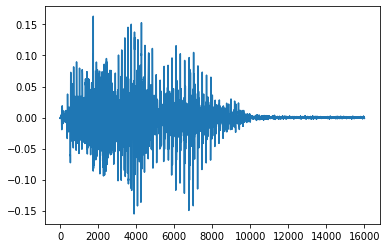

Listen to the first 1 second. Sampling rate is 16000


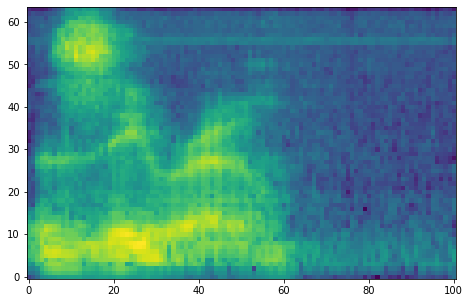

In [4]:
# Load example wave.
files = sorted(ROOT.glob('**/[a-z]*.wav'))

print(f'Training set has {len(files)} files. Last file:', files[-1])
waveform, sr = torchaudio.load(files[-1])
plt.plot(waveform.t().numpy()); plt.show()
print('Listen to the first 1 second. Sampling rate is', sr)
display(Audio(waveform[0, :sr], rate=sr))

# Instantiate mel spectrogram converter 
to_mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=cfg.sample_rate, n_fft=cfg.n_fft, n_mels=cfg.n_mels,
    hop_length=cfg.hop_length, f_min=cfg.f_min, f_max=cfg.f_max)

# Waveform to log-mel spectrogram
log_mel_spec = to_mel_spectrogram(waveform).log()

plt.figure(figsize=(18,5))
plt.imshow(log_mel_spec[0], origin='lower')

In [5]:
files = [str(f).replace(str(ROOT), '') for f in ROOT.glob('[a-z]*/*.wav')]
files = [f[1:] if f[0] == '/' else f for f in files]
print(f'Processing {len(files)} files...')
assert len(files) > 0

for f in files:
    # Load waveform
    waveform, sr = torchaudio.load(ROOT/f)
    # Resample
    if sr != cfg.sample_rate:
        waveform = torchaudio.transforms.Resample(sr, cfg.sample_rate)(waveform)
    # To log-mel spectrogram
    log_mel_spec = (to_mel_spectrogram(waveform) + torch.finfo(torch.float).eps).log()
    # Write to work folder
    f = WORK/f
    f.parent.mkdir(parents=True, exist_ok=True)
    np.save(f.with_suffix('.npy'), log_mel_spec)

Processing 105829 files...


In [6]:
import pandas as pd


val_files = [f.strip() for f in open(ROOT/'validation_list.txt').readlines()]
test_files = [f.strip() for f in open(ROOT/'testing_list.txt').readlines()]
df = pd.DataFrame({'filename': files})
df['label'] = [Path(f).parent.name for f in df.filename.values]
df['split'] = 'train'
df.loc[df.filename.isin(val_files), 'split'] = 'val'
df.loc[df.filename.isin(test_files), 'split'] = 'test'
df.filename = df.filename.str.replace('.wav', '.npy')

df.to_csv(WORK/'metadata.csv', index=False)

print(sum(df.split == 'train'), sum(df.split == 'val'), sum(df.split == 'test'))
print(len(df.label.unique()))

84843 9981 11005
35


## Training preparations


In [7]:
from byol_a.common import *
from byol_a.augmentations import PrecomputedNorm, RandomResizeCrop
from byol_a.models import AudioNTT2020
from sklearn.utils.class_weight import compute_class_weight

device = torch.device('cuda')

In [8]:
# Load preprocessed metadata.
df = pd.read_csv(WORK/'metadata.csv')
filenames, labels = {}, {}
for split in ['train', 'val', 'test']:
    filenames[split] = [WORK/f for f in df[df.split == split].filename.to_list()]
    labels[split] = df[df.split == split].label.to_list()

# Make a list of classes, converting labels into numbers
classes = sorted(set(labels['train'] + labels['test']))
for split in labels:
    labels[split] = [classes.index(label) for label in labels[split]]

print(filenames['train'][:3])
print(labels['train'][:3])
print(len(classes), classes[:3])


class_weight = compute_class_weight('balanced', range(len(classes)), labels['train'] )
print('class weight', class_weight)

all_train_lms = np.hstack([np.load(f)[0] for f in filenames['train'][:1000]])
train_mean_std = all_train_lms.mean(), all_train_lms.std()
print('training dataset log-mel spectrofram mean/std', train_mean_std)

[PosixPath('/content/work/spcv2/six/8e523821_nohash_3.npy'), PosixPath('/content/work/spcv2/six/cc6ee39b_nohash_1.npy'), PosixPath('/content/work/spcv2/six/e7ea8b76_nohash_4.npy')]
[25, 25, 25]
35 ['backward', 'bed', 'bird']
class weight [1.80095521 1.52075641 1.42845357 1.46293646 1.41676547 0.77347981
 0.79923696 0.7481746  1.9012437  1.93000455 0.82033358 0.78045258
 1.48534664 1.40363967 1.88498112 0.7981843  1.41759398 0.76469581
 0.77446828 0.81619048 0.7855106  0.77200182 0.80294326 0.756345
 1.50939335 0.78500185 0.77919824 0.81729121 1.72287542 0.77919824
 0.82228145 1.88205413 1.4060822  0.75095592 0.74587253]
training dataset log-mel spectrofram mean/std (-6.925201, 4.464217)


In [9]:
def sample_length(log_mel_spec):
    return log_mel_spec.shape[-1]


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, cfg, filenames, labels, transforms=None, norm_mean_std=None):
        assert len(filenames) == len(labels), f'Inconsistent length of filenames and labels.'

        self.filenames = filenames
        self.labels = labels
        self.transforms = transforms
        self.norm_mean_std = norm_mean_std

        # Calculate length of clip this dataset will make
        self.unit_length = cfg.unit_length

        # Test with first file
        assert self[0][0].shape[-1] == self.unit_length, f'Check your files, failed to load {filenames[0]}'

        # Show basic info.
        print(f'Dataset will yield log-mel spectrogram {len(self)} data samples in shape [1, {cfg.n_mels}, {self.unit_length}]')

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        assert 0 <= index and index < len(self)
        
        log_mel_spec = np.load(self.filenames[index])
        
        # normalize - instance based
        if self.norm_mean_std is not None:
            log_mel_spec = (log_mel_spec - self.norm_mean_std[0]) / self.norm_mean_std[1]

        # Padding if sample is shorter than expected - both head & tail are filled with 0s
        pad_size = self.unit_length - sample_length(log_mel_spec)
        if pad_size > 0:
            offset = pad_size // 2
            log_mel_spec = np.pad(log_mel_spec, ((0, 0), (0, 0), (offset, pad_size - offset)), 'constant')

        # Random crop
        crop_size = sample_length(log_mel_spec) - self.unit_length
        if crop_size > 0:
            start = np.random.randint(0, crop_size)
            log_mel_spec = log_mel_spec[..., start:start + self.unit_length]

        # Apply augmentations
        log_mel_spec = torch.Tensor(log_mel_spec)
        if self.transforms is not None:
            log_mel_spec = self.transforms(log_mel_spec)

        return log_mel_spec, self.labels[index]

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy
from dlcliche.torch_utils import IntraBatchMixup


class MyLearner(pl.LightningModule):

    def __init__(self, model, learning_rate=3e-4, mixup_alpha=0.4, weight=None, transpose_tfm=True):

        super().__init__()
        self.learning_rate = learning_rate
        self.model = model
        self.batch_mixer = IntraBatchMixup(nn.NLLLoss(weight=weight), alpha=mixup_alpha)
        self.transpose_tfm = transpose_tfm

    def forward(self, x):
        if self.transpose_tfm:
            x = x.squeeze(1).transpose(-1, -2) # (B, 1, F, T) -> (B, T, F)
        x = self.model(x)
        x = F.log_softmax(x, dim=1)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        x, stacked_ys = self.batch_mixer.transform(x, y, train=True)
        preds = self(x)
        loss = self.batch_mixer.criterion(preds, stacked_ys)
        return loss

    def validation_step(self, batch, batch_idx, split='val'):
        x, y = batch
        x, stacked_ys = self.batch_mixer.transform(x, y, train=False)
        preds = self(x)
        loss = self.batch_mixer.criterion(preds, stacked_ys)
        yhat = torch.argmax(preds, dim=1)
        acc = accuracy(yhat, y)

        self.log(f'{split}_loss', loss, prog_bar=True)
        self.log(f'{split}_acc', acc, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx, split='test')

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer

    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return valid_loader

    def test_dataloader(self):
        return test_loader

## Perceiver instantiation for mel spectrogram audio

- This model accepts input shaped `[batch, T, F]`, where T is a time frames, and F is a number of frequency bins, respectively.
- The parameter values are set to smaller numbers so that we can run on Colab. This could be the cause of lower performance.

In [11]:
from perceiver_pytorch import Perceiver

model = Perceiver(
    input_channels = 64,          # number of channels for each token of the input
    input_axis = 1,              # number of axis for input data (2 for images, 3 for video)
    num_freq_bands = 6,          # number of freq bands, with original value (2 * K + 1)
    max_freq = 10.,              # maximum frequency, hyperparameter depending on how fine the data is
    depth = 6,                   # depth of net
    num_latents = 128,           # number of latents, or induced set points, or centroids. different papers giving it different names
    latent_dim = 256,            # latent dimension
    cross_heads = 1,             # number of heads for cross attention. paper said 1
    latent_heads = 8,            # number of heads for latent self attention, 8
    cross_dim_head = 64,
    latent_dim_head = 64,
    num_classes = len(classes),          # output number of classes
    attn_dropout = 0.,
    ff_dropout = 0.,
    weight_tie_layers = True    # whether to weight tie layers (optional, as indicated in the diagram)
    #fourier_encode_data = True,  # whether to auto-fourier encode the data, using the input_axis given. defaults to True, but can be turned off if you are fourier encoding the data yourself
    #self_per_cross_attn = 2,      # number of self attention blocks per cross attention
    #self_attn_rel_pos = True
)

## Trains model

- The number of training epoch is restricted so that you can run on Colab. You can increase as you needed. (But it didn't improve with longer training epochs, as far as tested once)
- As far as tried, we need to change the way we use this Perceiver implementation, it could be essential to use the raw audio.

In [12]:
EPOCHS = 10
BS = 128

device = torch.device('cuda')
torch.backends.cudnn.benchmark = True

lms_size = [np.load(filenames['train'][0]).shape[1], cfg.unit_length]
augmentations = nn.Sequential(
    RandomResizeCrop(virtual_crop_scale=(1.0, 1.2), freq_scale=(0.8, 1.2), time_scale=(0.8, 1.2)),
)

train_dataset = MyDataset(cfg, filenames['train'], labels['train'], transforms=augmentations, norm_mean_std=train_mean_std)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BS, shuffle=True, pin_memory=True, num_workers=8)

valid_dataset = MyDataset(cfg, filenames['val'], labels['val'], norm_mean_std=train_mean_std)
test_dataset = MyDataset(cfg, filenames['test'], labels['test'], norm_mean_std=train_mean_std)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BS, pin_memory=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BS, pin_memory=True, num_workers=8)

learner = MyLearner(model, learning_rate=3e-4, mixup_alpha=0.2, weight=torch.Tensor(class_weight).to(device))
checkpoint = pl.callbacks.ModelCheckpoint(monitor='val_acc')
trainer = pl.Trainer(gpus=1, max_epochs=EPOCHS, callbacks=[checkpoint])
trainer.fit(learner);

learner.load_state_dict(torch.load(checkpoint.best_model_path)['state_dict'])
trainer.test(learner)

Dataset will yield log-mel spectrogram 84843 data samples in shape [1, 64, 100]
Dataset will yield log-mel spectrogram 9981 data samples in shape [1, 64, 100]
Dataset will yield log-mel spectrogram 11005 data samples in shape [1, 64, 100]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | Perceiver | 4.3 M 
------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.346    Total estimated model params size (MB)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9100409150123596, 'test_loss': 0.4067924916744232}
--------------------------------------------------------------------------------


[{'test_acc': 0.9100409150123596, 'test_loss': 0.4067924916744232}]

# Example Expected Result

- Training `AudioNTT2020` from a paper: [BYOL-A: Daisuke Niizumi, Daiki Takeuchi, Yasunori Ohishi, Noboru Harada, and Kunio Kashino "BYOL for Audio: Self-Supervised Learning for General-Purpose Audio Representation," IJCNN 2021](https://github.com/nttcslab/byol-a)
- Reaches to 95.8% accuracy without much effort, this is expected.


In [20]:
class AudioNTT2020Classifier(nn.Module):
    def __init__(self, num_classes, device, n_mels=64, d=2048, pretrained=True):
        super().__init__()
        self.body = AudioNTT2020(n_mels=n_mels, d=d)
        if pretrained:
            print('Loading pretrained weights.')
            self.body.load_weight(f'/content/byol-a/pretrained_weights/AudioNTT2020-BYOLA-64x96d{d}.pth', device)
        self.head = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(d, num_classes)
        )

    def forward(self, x):
        x = self.body(x)
        x = self.head(x)
        return x

model = AudioNTT2020Classifier(len(classes), device, pretrained=False)

In [21]:
train_dataset = MyDataset(cfg, filenames['train'], labels['train'], transforms=augmentations, norm_mean_std=train_mean_std)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BS, shuffle=True, pin_memory=True, num_workers=8)

valid_dataset = MyDataset(cfg, filenames['val'], labels['val'], norm_mean_std=train_mean_std)
test_dataset = MyDataset(cfg, filenames['test'], labels['test'], norm_mean_std=train_mean_std)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BS, pin_memory=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BS, pin_memory=True, num_workers=8)

learner = MyLearner(model, learning_rate=3e-4, mixup_alpha=0.2, weight=torch.Tensor(class_weight).to(device), transpose_tfm=False)
checkpoint = pl.callbacks.ModelCheckpoint(monitor='val_acc')
trainer = pl.Trainer(gpus=1, max_epochs=10, callbacks=[checkpoint])
trainer.fit(learner);

learner.load_state_dict(torch.load(checkpoint.best_model_path)['state_dict'])
trainer.test(learner)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | AudioNTT2020Classifier | 5.4 M 
-------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.574    Total estimated model params size (MB)


Dataset will yield log-mel spectrogram 84843 data samples in shape [1, 64, 100]
Dataset will yield log-mel spectrogram 9981 data samples in shape [1, 64, 100]
Dataset will yield log-mel spectrogram 11005 data samples in shape [1, 64, 100]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9589277505874634, 'test_loss': 0.2981370687484741}
--------------------------------------------------------------------------------


[{'test_acc': 0.9589277505874634, 'test_loss': 0.2981370687484741}]